<div id="introduction"></div>

> **BEFORE YOU READ:** While there are many types of compressors used in upstream production site applications (rotary vane, oil-flooded screw, centrifugal, reciprocating), I will explain with the screw compressor in mind, as this is where most of my experience lies.

Casing drawdown is a method used to improve artificial lift performance in wells equipped with downhole pumps like sucker rod pumps (SRPs) or electric submersible pumps (ESPs). These pumps often suffer from gas interference, which reduces efficiency, damages equipment, and leads to frequent shutdowns for repair.

By opening and connecting the casing side to a compressor, casing drawdown creates a dedicated gas outlet separate from the tubing. This separation eliminates gas intake into the pump, solving interference issues and enhancing reliability. The resulting decrease in bottomhole pressure also promotes additional reservoir inflow, boosting overall production. 

<div class="row" id="fig-1">
    <div class="col"><img src="jupyter_images/casing_drawdown_1.png"></div>
</div>
<div class="col-12 fig-title">
    <p class="image-description"><strong>Figure 1:</strong> Test</p>
</div>

<div class="solution_panel closed">
    <div class="solution_title">
        <p class="solution_title_string">Source Code For Figure (1)</p>
        <ul class="nav navbar-right panel_toolbox">
            <li><a class="collapse-link"><i class="fa fa-chevron-down"></i></a></li>
        </ul>
    <div class="clearfix"></div>
    </div>
    <div class="solution_content">
        <pre>
            <code class="language-python">
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from matplotlib.ticker import LogFormatter

# Load and preprocess data
df = pd.read_excel('sample_data/casing-drawdown.xlsx', sheet_name='single_well_1')
df.drop(columns=['Monthly Water', 'Monthly BOE'], inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df['Days in Month'] = df['Date'].dt.days_in_month

# Fill oil zeros with smoothed values
oil2 = df['Monthly Oil'].astype(float).copy()
i = 0
while i < len(oil2):
    if oil2[i] == 0:
        start = i
        while i < len(oil2) and oil2[i] == 0: i += 1
        if i < len(oil2):
            val = oil2[i] / (i - start + 1)
            oil2[start:i+1] = val
    else:
        i += 1

df.insert(df.columns.get_loc('Monthly Oil') + 1, 'Monthly Oil 2', oil2)
df['Daily Oil'] = df['Monthly Oil'] / df['Days in Month']
df['Daily Oil 2'] = df['Monthly Oil 2'] / df['Days in Month']
df['Daily Gas'] = df['Monthly Gas'] / df['Days in Month']

class PlainLogFormatter(LogFormatter):
    def __call__(self, x, pos=None):
        return f'{x:g}' if x in [0.01, 0.1, 1, 10, 100, 1000] else ''

fig, ax1 = plt.subplots(figsize=(8, 4.5))
ax2 = ax1.twinx()

# Plot oil & gas
ax1.plot(df['Date'], df['Daily Gas'], c='red', label='Gas')
ax2.plot(df['Date'], df['Daily Oil 2'], c='green', label='Oil')

# Axes styling
ax1.set(xlabel='Time', ylabel='Gas [MSCFD]', yscale='log', ylim=(0.1, 300))
ax2.set(ylabel='Oil [BBLD]', yscale='log', ylim=(0.1, 300))
ax1.yaxis.set_major_formatter(PlainLogFormatter())
ax2.yaxis.set_major_formatter(PlainLogFormatter())
ax1.grid(axis='y', alpha=0.5)
ax1.grid(axis='both', which='minor', linestyle='--', alpha=0.2)
ax1.spines.top.set_visible(False)
ax2.spines.top.set_visible(False)

# Time formatting
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.tick_params(axis='x', rotation=30, labelsize=9)

# Annotate install/release period
t1, t2 = pd.Timestamp('2016-10-23'), pd.Timestamp('2020-04-15')
ax1.axvline(t1, color='k', linestyle='--', lw=1.5)
ax1.axvline(t2, color='k', linestyle='--', lw=1.5)
ax1.axvspan(t1, t2, color='lightgrey', alpha=0.3, zorder=0)
ax1.annotate('Installed 10/2016', xy=(t1, ax1.get_ylim()[1]), xytext=(-5, 0),
             textcoords='offset points', rotation=90, va='top', ha='right', fontsize=9)
ax1.annotate('Released 4/2020', xy=(t2, ax1.get_ylim()[1]), xytext=(5, 0),
             textcoords='offset points', rotation=90, va='top', ha='left', fontsize=9)
ax1.text(t1 + (t2 - t1) / 2, 0.15, 'Install Period', ha='center', va='bottom',
         fontsize=10, fontweight='bold')

# Decline curve fit
def decline(t, qi, Di, b):
    return qi * np.exp(-Di * t) if b == 0 else qi * (1 + b * Di * t) ** (-1 / b)

params = {
    'Oil_pre': {'qi': 1.5, 'Di': 0.01, 'b': 0, 'start': 0},
    'Gas_pre': {'qi': 55, 'Di': 0.15, 'b': 0.8, 'start': 6},
    'Oil_post': {'qi': 2.7, 'Di': 0.01, 'b': 0, 'start': 40},
    'Gas_post': {'qi': 90, 'Di': 0.025, 'b': 0.8, 'start': 40},
}

t = np.arange(len(df))
x_plot = pd.date_range(df['Date'].iloc[0], periods=len(df), freq='MS')
df2 = pd.DataFrame(index=t)

for k, p in params.items():
    start = p.pop('start')
    curve = np.full(len(df), np.nan)
    curve[start:] = decline(np.arange(len(df) - start), **p)
    df2[k] = curve

# Plot fits
ax2.plot(x_plot, df2['Oil_pre'], ls='--', c='lightgreen')
ax2.plot(x_plot, df2['Oil_post'], ls='-', c='green')
ax1.plot(x_plot, df2['Gas_pre'], ls='--', c='lightcoral', alpha=0.5)
ax1.plot(x_plot, df2['Gas_post'], ls='--', c='red')

# Arrows + uplift label
ax2.annotate('', xy=(0.32, 0.415), xytext=(0.32, 0.285), xycoords='axes fraction',
             arrowprops=dict(arrowstyle='<->', color='black', lw=2))
ax2.text(0.335, 0.34, 'Uplift', transform=ax2.transAxes,
         va='center', ha='left', fontsize=12, fontweight='bold')
ax2.annotate('', xy=(0.32, 0.84), xytext=(0.32, 0.51), xycoords='axes fraction',
             arrowprops=dict(arrowstyle='<->', color='black', lw=2))
ax2.text(0.335, 0.675, 'Uplift', transform=ax2.transAxes,
         va='center', ha='left', fontsize=12, fontweight='bold')

# Inline values
ax2.text(df['Date'].iloc[33], 2.5, '2.7 BBLD', ha='right', color='green', fontsize=10)
ax2.text(df['Date'].iloc[36], 0.7, '1.2 BBLD', ha='left', color='green', fontsize=10)
ax1.text(df['Date'].iloc[36], 100, '92 MSCFD', ha='left', color='red', fontsize=10)
ax1.text(df['Date'].iloc[33], 5, '8 MSCFD', ha='right', color='red', fontsize=10)

# Title and footer
title = ' '.join([r"$\bf{" + w + "}$" for w in 'Casing Drawdown Compression,'.split()])
fig.suptitle(title + ' single vertical well', x=0, ha='left', fontsize=11)
ax1.annotate('', xy=(0.01, 0.91), xycoords='figure fraction', xytext=(1.02, 0.91),
             arrowprops=dict(arrowstyle="-", lw=0.7, color='k'))
ax1.text(0.98, 0.15, 'aegis4048.github.io', fontsize=10, ha='right',
         transform=ax1.transAxes, color='grey', alpha=0.5)

fig.tight_layout()
            </code>
        </pre>
    </div>
</div>

<div class="row" id="fig-2">
    <div class="col"><img src="jupyter_images/casing_drawdown_2.png"></div>
</div>
<div class="col-12 fig-title">
    <p class="image-description"><strong>Figure 2:</strong> Test</p>
</div>

* phase envelope - holding 50# vs 200# pressure - less gas breakout at the pump instake - eventually breaksout as it comes up, but no reduced gas at the intake. Note that in reality, if backpressure is reduced, the GOR will change so the compositions will change, and envelope will change - just think of this is approximiate illustration to understand the how it works. 

* some gas break out from the liquids and collect in the casing, increasing casing pressure. This exerts back pressure on the formation, reducing production rate. 

* Difference between BHP vs. formation P drives fluid flow.
* Difference between WHP vs. BHP drives fluids up the tubing. 

* Opening casing side directly to the flowline without compressor doesn't do anything. 

* This effect will be more significant on low pressure formations
    - Formation pressure of 20700 kPa(3000 psi), well is 1380 kPa(200 psi), drops to 207 kPa(30 psi), change is 6%
    - Formation pressure is 6894 kPa(1000 psi), well is 1380 kPa(200 psi), drops to 207 kPa(30 psi), change is 18%
    
* Increasing fluid height, or increasing choke back pressure can be used to reduce gas breakout. This sacrifices overall hydrocarbon production to supress gaslock issues. 

0. Terminalogy
    - Pulling down / drawdown = it means drawing gas, there by reducing down pressure. Pulls from casing, pulls on casing, draw from casing, they all mean the same thing.
    - Casing drawdown
    - Backside compression -> This is not injection. No gaslift injection. Backside refers to casing side, which means the tubing side would be font (but no one calls it front-side, its always called tubing side)
    - Casing annulus - When you say casing side, more specifically it means pulling
    - Wellhead compression -> This can mean three things -> gas lift injection, separator drawdown, or casing drawdown. All of these have excert influence on casing. This is unfortunate terminology used my many in the industry despite its ambiguity. 

1. Problem Statement
    - Gas Interference
        * Reduced pump efficiency. Explain with rod pump working structure
        * Detection - show dynocards
        * Pump placement, spacing, holding backpressure: can only do so much. Opening casing side is the complete solution. But comes with cost. 
    - Backpressure on formation

2. Working Principle
    * path of the least resistance.
    * Works as a giant 2-phase separator
    * Liquid can't flowup the tubing due to larger annulus area than tubing side, must overcome critical rate, but this is uncommon - exception for ESPs. Because rod pumps are usually installed at late life of the well.
    * 
    2.1. - Potential Casing-Side Liquid Flow
    * (show a critical rate plot, refer to appendix A for critical rate calculation). Though this depends on casing OD/IDs, but typically 
    * For most applications, minimal to no liquids will come up the casing. Different story for ESPs. Most applications don't require test separators.... try and see if needed.
    2.2. - Casing vs. Tubing Differential Pressure
    * This value must be higher than the casing side bottomhole pressure. Bottomhole P = surface casing P + gas column P + liquid column P, where gas column P is negiligble compared to the other two. If the fluid level in the casing annulus at the bottom is too high, the liquid back pressure + whatever the suction pressure is, can be bigger than the differential P and prevent gas flow up the casing. This liquid column level must be sufficiently reduced by either manually operating the pump at a bigger capacity or swabbing the well (not sure if casing annulus can be swabbed, ask paul) to kick start the well.
    * https://www.downholediagnostic.com/fluid-level (fluid level calculatrion is not that simple due to gasesous liquid column) - if gas doesn't come up the casing 
    
    
3. Benefits
    - Reservoir uplift due to reduced bottomhole pressure
    - Improved pump efficiency
    - Simple setup, risk free
        - No site preparation needed
        - Minimal pipe fitting needed
        - no hot work required. 
        
4. Pipe Layouts
    * single well, multi-well, test separator, route gas to WH flowline, route gas to salesline downstream of sep
    
5. Operational concerns
    5.1. - Observation period - read Justin Welch's email.
    5.2. - Test separator
    5.3. - Bigger compressor may be needed
    5.4. - Wellsite testing
    
6. Candidate well selection

    * High GOR pumping wells - high likelyhood of pump damage or bad efficiency.
    * High backpressure on formation - salesline, or artificial choke to suppress gas. The bigger the P drop, more gain. Potentially explain deltaP effect on Darcy Equation & IPR curve. 
    * High permeability wells - Show IPR curve. 

7. Case Studies
    6.1 Case 1 - setups, results, motivation, economics
    6.2 Case 2 - setups, results, motivation, economics

1. Casing Drawdown Working Mechanism
2. Surface Pipe Layouts
3. Applications
    - Pressure drawdown
    - multi-well drawdown. Not much drawdown, but fixes inteference problems. Smoother operation.
4. Benefits
    - Reservoir uplift due to reduced bototmhole pressure
    - Improved pump efficiency
    - Simple setup, risk free
        - No site preparation needed
        - Minimal pipe fitting needed
        - no hot work required. 
    
5. Critical rate
    - Velocity string - reduced critical rate needed, but doesn't give increased production
    - compression - direct reservoir uplift
6. LOE comparison
7. Operational concerns
    - Observation period
    - Test separator
    - Bigger compressor - uplift maybe so big that you may need a bigger compressor.
    - Testing is critical - try on one well in a region with small production. Small units can be trailer-mounted and can be tested at a low cost. Gas engine units are easier for testing, as there's no need for electrician to hookup power. If proved successful and power is available, consider switching to electric units later for other permanent installations if desired.
    - shutdowns - will result in drop in flowrate, and potential damage to pumps. Pumps maybe fine for short periods of compressor shutdown. If you don't like it, can set auto join-shutdown, or autobypass the pump. 
8. Candidate Selection
    - Severe Gas interferance
    - High backpressure on formation
        * Artifically high P with choke or increased liquid column
        * Or high sales line pressure
    - High permeability wells
9. IPR ratio curve
    - Show impact of permeability
    - Assume fixed GOR - oil can increase can be used as a proxy to predict gas increase. 
    - Add an explanation that these are all theories. In real-life applications, its "test and see".

"Wellbore fluids can now flow more freely into the well bore and this pulldown of pressure can create a “drain-point” for the formation. There have been times when the “oil cut” has also increased by pulling down the casing pressure. Initial test results after just a day or two may be misleading because of oil that is stacked in the casing  may be 4-6 barrels or more, so the pulldown may have some high oil production for the first day or two, so a one-week to a two-week test is recommended. Just reducing the casing pressure from 20 psi to below zero can have a dramatic effect on oil production. With little fluid production being made up the casing many types of compressors can be used for this operation. "



# Questions

1. Why can't you connect the casing side directly to the compressor, if the goal is only to reduce gas intake to the pump? While it doesn't reduce bottomhole pressure, it will still mitigate gas interference.

2. If salesline pressure is 200# on average, what discharge setpoint pressure would you set on compressor? How does discharge pressure respond to changing line pressures?

3. Can you mix the discharge gas line to the liquid inlet to a separator like shown here (https://www.compactcompression.com/Compression101-CasingGasCompression.html) or do you mix it on gas outlet line of a separator?

4. Can you swab the casing annulus of the well? 

5. For suction scrubber dump liquid for wellhead applications, where do you route it to? Don't they have oil? Dumping to oil tank has water separation issues, and dumping to water tank wastes oil. If heater operates at high pressure, you gotta dump to either water or oil tank. 

# Questions to Clayton

1. For engine units, when you first start the compressor, how do you get the fuel gas from when there's no flow yet? 
2. Does it work the same way for casing drawdown applications? 

# Todo
Get 

Casing drawdown

* Pulls gas from casing.
* uses compressor
* used for wells that use downhole pumps.
* downhole pumps suffer with gas interference problems.
* downhole pupms: SRP and ESP
* The pumps efficiency decreases, pump dmg happens, triggers shutdown for pump repair, which decreases production.
* The pumps are designed to minimize gas intake to the tubing side, but they can only do so much when tubing side is the only open side. Equipment dmg and reduced efficiency is inevitable, though the degree of severity depends well by well.
* Solves gas inteference problems by opening the casing side, and separate gas from liquid. It also contributes to lowering the bottomhole pressure of the well, resulting in reservoir uplift. 
* There's also uplift due to increased efficiency and reduced pump repair downtime. 

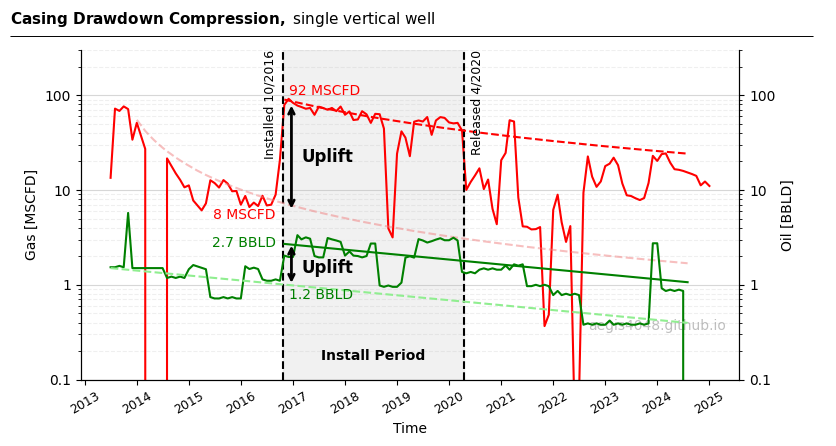

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from matplotlib.ticker import LogFormatter

# Load and preprocess data
df = pd.read_excel('sample_data/casing-drawdown.xlsx', sheet_name='single_well_1')
df.drop(columns=['Monthly Water', 'Monthly BOE'], inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df['Days in Month'] = df['Date'].dt.days_in_month

# Fill oil zeros with smoothed values
oil2 = df['Monthly Oil'].astype(float).copy()
i = 0
while i < len(oil2):
    if oil2[i] == 0:
        start = i
        while i < len(oil2) and oil2[i] == 0: i += 1
        if i < len(oil2):
            val = oil2[i] / (i - start + 1)
            oil2[start:i+1] = val
    else:
        i += 1

df.insert(df.columns.get_loc('Monthly Oil') + 1, 'Monthly Oil 2', oil2)
df['Daily Oil'] = df['Monthly Oil'] / df['Days in Month']
df['Daily Oil 2'] = df['Monthly Oil 2'] / df['Days in Month']
df['Daily Gas'] = df['Monthly Gas'] / df['Days in Month']

class PlainLogFormatter(LogFormatter):
    def __call__(self, x, pos=None):
        return f'{x:g}' if x in [0.01, 0.1, 1, 10, 100, 1000] else ''

fig, ax1 = plt.subplots(figsize=(8, 4.5))
ax2 = ax1.twinx()

# Plot oil & gas
ax1.plot(df['Date'], df['Daily Gas'], c='red', label='Gas')
ax2.plot(df['Date'], df['Daily Oil 2'], c='green', label='Oil')

# Axes styling
ax1.set(xlabel='Time', ylabel='Gas [MSCFD]', yscale='log', ylim=(0.1, 300))
ax2.set(ylabel='Oil [BBLD]', yscale='log', ylim=(0.1, 300))
ax1.yaxis.set_major_formatter(PlainLogFormatter())
ax2.yaxis.set_major_formatter(PlainLogFormatter())
ax1.grid(axis='y', alpha=0.5)
ax1.grid(axis='both', which='minor', linestyle='--', alpha=0.2)
ax1.spines.top.set_visible(False)
ax2.spines.top.set_visible(False)

# Time formatting
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.tick_params(axis='x', rotation=30, labelsize=9)

# Annotate install/release period
t1, t2 = pd.Timestamp('2016-10-23'), pd.Timestamp('2020-04-15')
ax1.axvline(t1, color='k', linestyle='--', lw=1.5)
ax1.axvline(t2, color='k', linestyle='--', lw=1.5)
ax1.axvspan(t1, t2, color='lightgrey', alpha=0.3, zorder=0)
ax1.annotate('Installed 10/2016', xy=(t1, ax1.get_ylim()[1]), xytext=(-5, 0),
             textcoords='offset points', rotation=90, va='top', ha='right', fontsize=9)
ax1.annotate('Released 4/2020', xy=(t2, ax1.get_ylim()[1]), xytext=(5, 0),
             textcoords='offset points', rotation=90, va='top', ha='left', fontsize=9)
ax1.text(t1 + (t2 - t1) / 2, 0.15, 'Install Period', ha='center', va='bottom',
         fontsize=10, fontweight='bold')

# Decline curve fit
def decline(t, qi, Di, b):
    return qi * np.exp(-Di * t) if b == 0 else qi * (1 + b * Di * t) ** (-1 / b)

params = {
    'Oil_pre': {'qi': 1.5, 'Di': 0.01, 'b': 0, 'start': 0},
    'Gas_pre': {'qi': 55, 'Di': 0.15, 'b': 0.8, 'start': 6},
    'Oil_post': {'qi': 2.7, 'Di': 0.01, 'b': 0, 'start': 40},
    'Gas_post': {'qi': 90, 'Di': 0.025, 'b': 0.8, 'start': 40},
}

t = np.arange(len(df))
x_plot = pd.date_range(df['Date'].iloc[0], periods=len(df), freq='MS')
df2 = pd.DataFrame(index=t)

for k, p in params.items():
    start = p.pop('start')
    curve = np.full(len(df), np.nan)
    curve[start:] = decline(np.arange(len(df) - start), **p)
    df2[k] = curve

# Plot fits
ax2.plot(x_plot, df2['Oil_pre'], ls='--', c='lightgreen')
ax2.plot(x_plot, df2['Oil_post'], ls='-', c='green')
ax1.plot(x_plot, df2['Gas_pre'], ls='--', c='lightcoral', alpha=0.5)
ax1.plot(x_plot, df2['Gas_post'], ls='--', c='red')

# Arrows + uplift label
ax2.annotate('', xy=(0.32, 0.415), xytext=(0.32, 0.285), xycoords='axes fraction',
             arrowprops=dict(arrowstyle='<->', color='black', lw=2))
ax2.text(0.335, 0.34, 'Uplift', transform=ax2.transAxes,
         va='center', ha='left', fontsize=12, fontweight='bold')
ax2.annotate('', xy=(0.32, 0.84), xytext=(0.32, 0.51), xycoords='axes fraction',
             arrowprops=dict(arrowstyle='<->', color='black', lw=2))
ax2.text(0.335, 0.675, 'Uplift', transform=ax2.transAxes,
         va='center', ha='left', fontsize=12, fontweight='bold')

# Inline values
ax2.text(df['Date'].iloc[33], 2.5, '2.7 BBLD', ha='right', color='green', fontsize=10)
ax2.text(df['Date'].iloc[36], 0.7, '1.2 BBLD', ha='left', color='green', fontsize=10)
ax1.text(df['Date'].iloc[36], 100, '92 MSCFD', ha='left', color='red', fontsize=10)
ax1.text(df['Date'].iloc[33], 5, '8 MSCFD', ha='right', color='red', fontsize=10)

# Title and footer
title = ' '.join([r"$\bf{" + w + "}$" for w in 'Casing Drawdown Compression,'.split()])
fig.suptitle(title + ' single vertical well', x=0, ha='left', fontsize=11)
ax1.annotate('', xy=(0.01, 0.91), xycoords='figure fraction', xytext=(1.02, 0.91),
             arrowprops=dict(arrowstyle="-", lw=0.7, color='k'))
ax1.text(0.98, 0.15, 'aegis4048.github.io', fontsize=10, ha='right',
         transform=ax1.transAxes, color='grey', alpha=0.5)

fig.tight_layout()


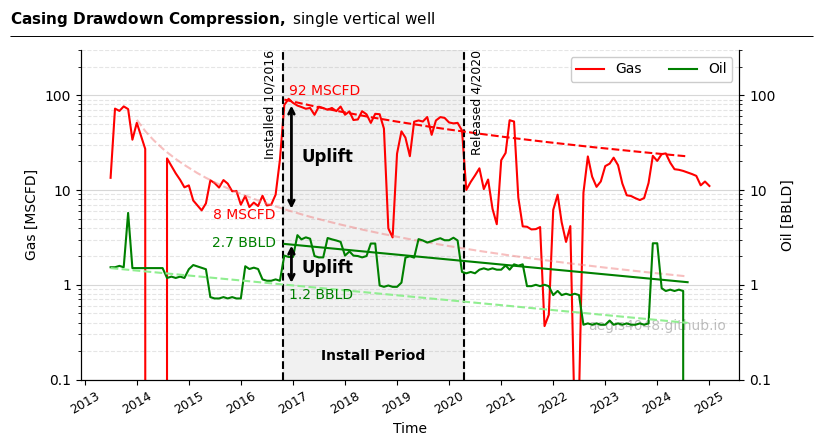

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from matplotlib.ticker import LogFormatter

file = 'sample_data/casing-drawdown.xlsx'

df = pd.read_excel(file, sheet_name='single_well_1')
df = df.drop(columns=['Monthly Water', 'Monthly BOE'])

oil2 = df['Monthly Oil'].astype(float).copy()
i = 0
while i < len(oil2):
    if oil2[i] == 0:
        start = i
        while i < len(oil2) and oil2[i] == 0:
            i += 1
        if i < len(oil2):
            val = oil2[i] / (i - start + 1)
            oil2[start:i+1] = val
    else:
        i += 1

df.insert(df.columns.get_loc('Monthly Oil') + 1, 'Monthly Oil 2', oil2)

df['Date'] = pd.to_datetime(df['Date'])
df['Days in Month'] = df['Date'].dt.days_in_month
df['Daily Oil'] = df['Monthly Oil'] / df['Days in Month']
df['Daily Oil 2'] = df['Monthly Oil 2'] / df['Days in Month']
df['Daily Gas'] = df['Monthly Gas'] / df['Days in Month']

class PlainLogFormatter(LogFormatter):
    def __call__(self, x, pos=None):
        # Format ticks like 0.1, 1, 10, 100 instead of 1e1
        if x in [0.1, 1, 10, 100, 1000, 0.01]:
            return f'{x:g}'
        return ''

    
fig, ax1 = plt.subplots(figsize=(8, 4.5))
ax2 = ax1.twinx()

oc = 'green'
gc = 'red'

ax1.plot(df['Date'], df['Daily Gas'], c=gc, label='Gas')
ax2.plot(df['Date'], df['Daily Oil 2'], c=oc, label='Oil')

ax1.yaxis.get_major_ticks()[5].gridline.set_visible(False)
ax1.spines.top.set_visible(False)
ax2.spines.top.set_visible(False)

ax1.set_xlabel('Time')
ax1.set_ylabel('Gas [MSCFD]')
ax2.set_ylabel('Oil [BBLD]')

ax1.grid(axis='both', which='minor', color='grey', linestyle='--', alpha=0.2)
ax1.grid(axis='y', alpha=0.5)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, fontsize=10, ncol=3, loc='upper right', framealpha=1)

ax1.set_yscale('log')
ax2.set_yscale('log')
ax1.set_ylim(0.1, 300)
ax2.set_ylim(0.1, 300)

formatter = PlainLogFormatter(labelOnlyBase=False)
ax1.yaxis.set_major_formatter(formatter)
ax2.yaxis.set_major_formatter(formatter)

ax1.xaxis.set_major_locator(mdates.YearLocator(1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.tick_params(axis='x', labelrotation=30, labelsize=9)

t1 = pd.Timestamp('2016-10-23')
t2 = pd.Timestamp('2020-04-15')

ax1.axvline(t1, color='k', linestyle='--', lw=1.5)
ax1.axvline(t2, color='k', linestyle='--', lw=1.5)
ax1.axvspan(t1, t2, color='lightgrey', alpha=0.3, zorder=0)

ax1.annotate('Installed 10/2016', xy=(t1, ax1.get_ylim()[1]), xytext=(-5, 0),
             textcoords='offset points', rotation=90, va='top', ha='right', fontsize=9)
ax1.annotate('Released 4/2020', xy=(t2, ax1.get_ylim()[1]), xytext=(5, 0),
             textcoords='offset points', rotation=90, va='top', ha='left', fontsize=9)

mid = t1 + (t2 - t1) / 2
ax1.text(mid, 0.15, 'Install Period',
         ha='center', va='bottom', fontsize=10, fontweight='bold')

def general_decline(t, qi, Di, b):
    if b == 0:
        return qi * np.exp(-Di * t)
    return qi * (1 + b * Di * t) ** (-1 / b)

params = {
    'Oil_pre': {'qi': 1.5, 'Di': 0.01, 'b': 0, 'start': 0},
    'Gas_pre': {'qi': 55, 'Di': 0.15, 'b': 0.7, 'start': 6},
    'Oil_post': {'qi': 2.7, 'Di': 0.01, 'b': 0, 'start': 40},
    'Gas_post': {'qi': 90, 'Di': 0.025, 'b': 0.7, 'start': 40},
}

t_full = np.arange(len(df))
x_plot = pd.date_range(start=df['Date'].iloc[0], periods=len(df), freq='MS')

df2 = pd.DataFrame(index=t_full)

for key, p in params.items():
    start = p.pop('start')
    t_sub = np.arange(len(df) - start)
    fit = general_decline(t_sub, **p)
    full_curve = np.full(len(df), np.nan)
    full_curve[start:] = fit
    df2[key] = full_curve

ax2.plot(x_plot, df2['Oil_pre'], ls='--', c='lightgreen', label='Oil Fit')
ax2.plot(x_plot, df2['Oil_post'], ls='-', c='green', label='Oil Fit')
ax1.plot(x_plot, df2['Gas_pre'], ls='--', c='lightcoral', label='Gas Fit', alpha=0.5)
ax1.plot(x_plot, df2['Gas_post'], ls='--', c='red', label='Gas Fit')

x_arrow = 0.32
ax2.annotate('', xy=(x_arrow, 0.415), xytext=(x_arrow, 0.285),  # x_frac, y1_frac to y0_frac
             xycoords='axes fraction',
             arrowprops=dict(arrowstyle='<->', color='black', lw=2),
             annotation_clip=False)
ax2.text(x_arrow + 0.015, 0.34, 'Uplift', transform=ax2.transAxes,
         va='center', ha='left', fontsize=12, fontweight='bold')

ax2.annotate('', xy=(x_arrow, 0.84), xytext=(x_arrow, 0.51),  # x_frac, y1_frac to y0_frac
             xycoords='axes fraction',
             arrowprops=dict(arrowstyle='<->', color='black', lw=2),
             annotation_clip=False)
ax2.text(x_arrow + 0.015, 0.675, 'Uplift', transform=ax2.transAxes,
         va='center', ha='left', fontsize=12, fontweight='bold')


ax2.text(df['Date'].iloc[33], 2.5, '2.7 BBLD', ha='right', color=oc, fontsize=10)
ax2.text(df['Date'].iloc[36], 0.7, '1.2 BBLD', ha='left', color=oc, fontsize=10)

ax1.text(df['Date'].iloc[36], 100, '92 MSCFD', ha='left', color=gc, fontsize=10)
ax1.text(df['Date'].iloc[33], 5, '8 MSCFD', ha='right', color=gc, fontsize=10)

def setbold(txt):
    return ' '.join([r"$\bf{" + item + "}$" for item in txt.split(' ')])

bold_txt = setbold('Casing Drawdown Compression, ')
plain_txt = 'single vertical well'
fig.suptitle(bold_txt + plain_txt, verticalalignment='top', x=0, horizontalalignment='left', fontsize=11)
yloc = 0.9
ax1.annotate('', xy=(0.01, yloc + 0.01), xycoords='figure fraction', xytext=(1.02, yloc + 0.01),
            arrowprops=dict(arrowstyle="-", color='k', lw=0.7))

ax1.text(0.98, 0.15, 'aegis4048.github.io', fontsize=10, ha='right', transform=ax1.transAxes, color='grey', alpha=0.5)

fig.tight_layout()

In [4]:
fig.savefig('casing_drawdown_1.png', dpi=200, bbox_inches='tight')

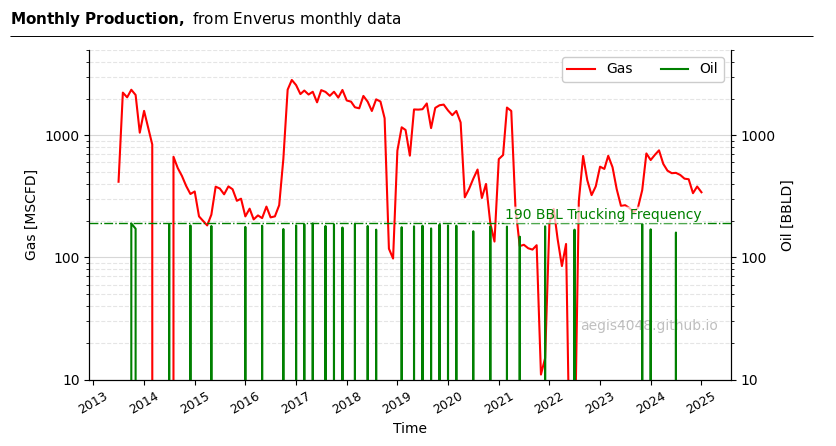

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from matplotlib.ticker import LogFormatter

file = 'sample_data/casing-drawdown.xlsx'

df = pd.read_excel(file, sheet_name='single_well_1')
df = df.drop(columns=['Monthly Water', 'Monthly BOE'])

oil2 = df['Monthly Oil'].astype(float).copy()
i = 0
while i < len(oil2):
    if oil2[i] == 0:
        start = i
        while i < len(oil2) and oil2[i] == 0:
            i += 1
        if i < len(oil2):
            val = oil2[i] / (i - start + 1)
            oil2[start:i+1] = val
    else:
        i += 1

df.insert(df.columns.get_loc('Monthly Oil') + 1, 'Monthly Oil 2', oil2)

df['Date'] = pd.to_datetime(df['Date'])
df['Days in Month'] = df['Date'].dt.days_in_month
df['Daily Oil'] = df['Monthly Oil'] / df['Days in Month']
df['Daily Oil 2'] = df['Monthly Oil 2'] / df['Days in Month']
df['Daily Gas'] = df['Monthly Gas'] / df['Days in Month']

class PlainLogFormatter(LogFormatter):
    def __call__(self, x, pos=None):
        # Format ticks like 0.1, 1, 10, 100 instead of 1e1
        if x in [0.1, 1, 10, 100, 1000, 0.01]:
            return f'{x:g}'
        return ''


fig, ax1 = plt.subplots(figsize=(8, 4.5))
ax2 = ax1.twinx()

oc = 'green'
gc = 'red'

ax1.plot(df['Date'], df['Monthly Gas'], c=gc, label='Gas')
ax2.plot(df['Date'], df['Monthly Oil'], c=oc, label='Oil')

ax1.yaxis.get_major_ticks()[5].gridline.set_visible(False)
ax1.spines.top.set_visible(False)
ax2.spines.top.set_visible(False)

ax1.set_xlabel('Time')
ax1.set_ylabel('Gas [MSCFD]')
ax2.set_ylabel('Oil [BBLD]')

ax1.grid(axis='both', which='minor', color='grey', linestyle='--', alpha=0.2)
ax1.grid(axis='y', alpha=0.5)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, fontsize=10, ncol=3, loc='upper right', framealpha=1)

ax1.set_yscale('log')
ax2.set_yscale('log')
ax1.set_ylim(10, 5000)
ax2.set_ylim(10, 5000)

ax2.axhline(y=190, c=oc,  lw=1, ls='-.')
ax2.text(df['Date'].iloc[-1], 195, '190 BBL Trucking Frequency',
         va='bottom', ha='right', color=oc,
         bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1', alpha=0.7))

formatter = PlainLogFormatter(labelOnlyBase=False)
ax1.yaxis.set_major_formatter(formatter)
ax2.yaxis.set_major_formatter(formatter)

ax1.xaxis.set_major_locator(mdates.YearLocator(1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.tick_params(axis='x', labelrotation=30, labelsize=9)


def setbold(txt):
    return ' '.join([r"$\bf{" + item + "}$" for item in txt.split(' ')])

bold_txt = setbold('Monthly Production, ')
plain_txt = 'from Enverus monthly data'
fig.suptitle(bold_txt + plain_txt, verticalalignment='top', x=0, horizontalalignment='left', fontsize=11)
yloc = 0.9
ax1.annotate('', xy=(0.01, yloc + 0.01), xycoords='figure fraction', xytext=(1.02, yloc + 0.01),
            arrowprops=dict(arrowstyle="-", color='k', lw=0.7))

ax1.text(0.98, 0.15, 'aegis4048.github.io', fontsize=10, ha='right', transform=ax1.transAxes, color='grey', alpha=0.5)

fig.tight_layout()

In [9]:
df_orig = pd.read_excel(file, sheet_name='multi_well_2')
df_orig['Monthly Production Date'] = pd.to_datetime(df_orig['Monthly Production Date'])
df = df_orig.groupby('Monthly Production Date')[['Monthly Oil', 'Monthly Gas', 'Monthly Water', 'Monthly BOE']].sum().reset_index()

df = df.sort_values('Monthly Production Date').reset_index(drop=True)

In [10]:
df

,Monthly Production Date,Monthly Oil,Monthly Gas,Monthly Water,Monthly BOE
0,2008-05-01,364,111,41,382.50
1,2008-06-01,1584,1641,177,1857.50
2,2008-07-01,1092,1342,122,1315.67
3,2008-08-01,631,911,71,782.83
4,2008-09-01,1041,705,116,1158.50
...,...,...,...,...,...
197,2024-10-01,655,7761,2027,1948.51
198,2024-11-01,745,7620,2305,2014.99
199,2024-12-01,777,8234,2404,2149.34
200,2025-01-01,743,7428,2299,1981.00


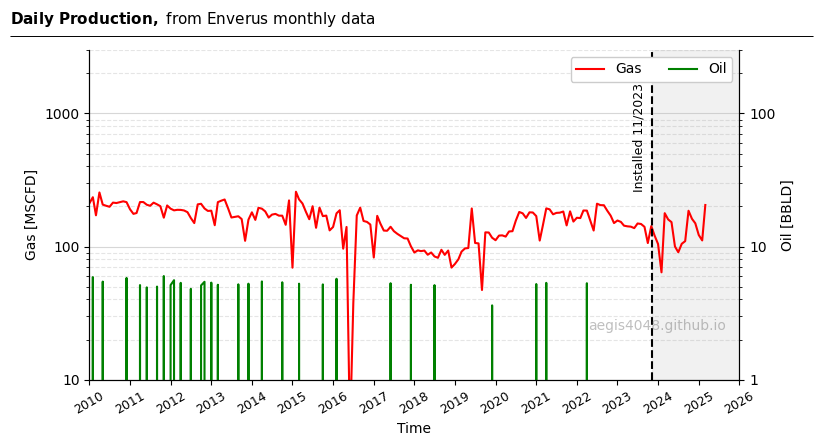

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from matplotlib.ticker import LogFormatter
class PlainLogFormatter(LogFormatter):
    def call(self, x, pos=None):
        return f'{x:g}' if x in [0.01, 0.1, 1, 10, 100, 1000] else ''

file = 'julius monthly Well Monthly Production.CSV'

df_orig = pd.read_csv(file)
df_orig['Date'] = pd.to_datetime(df_orig['Date'])
df = df_orig.groupby('Date')[['Monthly Oil', 'Monthly Gas', 'Monthly Water', 'Monthly BOE']].sum().reset_index()
df = df.sort_values('Date').reset_index(drop=True)

df['Date'] = pd.to_datetime(df['Date'])
df['Days in Month'] = df['Date'].dt.days_in_month
df['Daily Oil'] = df['Monthly Oil'] / df['Days in Month']
df['Daily Gas'] = df['Monthly Gas'] / df['Days in Month']

fig, ax1 = plt.subplots(figsize=(8, 4.5))
ax2 = ax1.twinx()

oc = 'green'
gc = 'red'

ax1.plot(df['Date'], df['Daily Gas'], c=gc, label='Gas')
ax2.plot(df['Date'], df['Daily Oil'], c=oc, label='Oil')

t1 = pd.Timestamp('2023-11-10')
t2 = pd.Timestamp('2016-01-31')

t2 = pd.Timestamp(mdates.num2date(ax1.get_xlim()[1])).normalize()

ax1.axvline(t1, color='k', linestyle='--', lw=1.5)
ax1.axvline(t2, color='k', linestyle='--', lw=1.5)
ax1.axvspan(t1, t2, color='lightgrey', alpha=0.3, zorder=0)

ax1.annotate(f'Installed {t1:%m/%Y}', xy=(t1, ax1.get_ylim()[1]), xytext=(-5, 0),
             textcoords='offset points', rotation=90, va='top', ha='right', fontsize=9)
ax1.annotate(f'Installed {t2:%m/%Y}', xy=(t2, ax1.get_ylim()[1]), xytext=(5, 0),
             textcoords='offset points', rotation=90, va='top', ha='left', fontsize=9)

ax1.yaxis.get_major_ticks()[5].gridline.set_visible(False)
ax1.spines.top.set_visible(False)
ax2.spines.top.set_visible(False)

ax1.set_xlabel('Time')
ax1.set_ylabel('Gas [MSCFD]')
ax2.set_ylabel('Oil [BBLD]')

ax1.grid(axis='both', which='minor', color='grey', linestyle='--', alpha=0.2)
ax1.grid(axis='y', alpha=0.5)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, fontsize=10, ncol=3, loc='upper right', framealpha=1)

ax1.set_yscale('log')
ax2.set_yscale('log')
ax1.set_ylim(10, 3000)
ax2.set_ylim(1, 300)
ax1.set_xlim(left=pd.Timestamp('2010'), right=pd.Timestamp('2026'))

formatter = PlainLogFormatter(labelOnlyBase=False)
ax1.yaxis.set_major_formatter(formatter)
ax2.yaxis.set_major_formatter(formatter)

ax1.xaxis.set_major_locator(mdates.YearLocator(1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.tick_params(axis='x', labelrotation=30, labelsize=9)

def setbold(txt):
    return ' '.join([r"$\bf{" + item + "}$" for item in txt.split(' ')])

bold_txt = setbold('Daily Production, ')
plain_txt = 'from Enverus monthly data'
fig.suptitle(bold_txt + plain_txt, verticalalignment='top', x=0, horizontalalignment='left', fontsize=11)
yloc = 0.9
ax1.annotate('', xy=(0.01, yloc + 0.01), xycoords='figure fraction', xytext=(1.02, yloc + 0.01),
            arrowprops=dict(arrowstyle="-", color='k', lw=0.7))

ax1.text(0.98, 0.15, 'aegis4048.github.io', fontsize=10, ha='right', transform=ax1.transAxes, color='grey', alpha=0.5)

fig.tight_layout()

In [13]:
xmax

21155.4

In [17]:
pd.Timestamp('2016-01-31')

Timestamp('2016-01-31 00:00:00')

In [16]:
pd.Timestamp(mdates.num2date(ax1.get_xlim()[1])).normalize()

Timestamp('2027-12-03 00:00:00+0000', tz='UTC')